<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li></ul></li><li><span><a href="#Load-Trip-Data" data-toc-modified-id="Load-Trip-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Trip Data</a></span><ul class="toc-item"><li><span><a href="#Average-Charging-Speed" data-toc-modified-id="Average-Charging-Speed-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Average Charging Speed</a></span></li></ul></li><li><span><a href="#Error-Check" data-toc-modified-id="Error-Check-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Error Check</a></span><ul class="toc-item"><li><span><a href="#Trips-that-start-and-end-at-the-same-address" data-toc-modified-id="Trips-that-start-and-end-at-the-same-address-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Trips that start and end at the same address</a></span></li><li><span><a href="#EVs-charged-while-parking-without-being-at-charger" data-toc-modified-id="EVs-charged-while-parking-without-being-at-charger-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EVs charged while parking without being at charger</a></span></li><li><span><a href="#EV-lost-Charge-at-Charger" data-toc-modified-id="EV-lost-Charge-at-Charger-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>EV lost Charge at Charger</a></span></li><li><span><a href="#Determine-trips-where-EV-was-charging-before-appearing-at-charging-station" data-toc-modified-id="Determine-trips-where-EV-was-charging-before-appearing-at-charging-station-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Determine trips where EV was charging before appearing at charging station</a></span></li><li><span><a href="#Charged-on-trip-without-ending-at-charger" data-toc-modified-id="Charged-on-trip-without-ending-at-charger-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Charged on trip without ending at charger</a></span></li></ul></li><li><span><a href="#Demand-Patterns" data-toc-modified-id="Demand-Patterns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Demand Patterns</a></span><ul class="toc-item"><li><span><a href="#Yearly-rental-patterns" data-toc-modified-id="Yearly-rental-patterns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Yearly rental patterns</a></span></li><li><span><a href="#Weekly-Pattern-of-connected-EVS" data-toc-modified-id="Weekly-Pattern-of-connected-EVS-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Weekly Pattern of connected EVS</a></span><ul class="toc-item"><li><span><a href="#Example-Week" data-toc-modified-id="Example-Week-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Example Week</a></span></li></ul></li><li><span><a href="#Daily-Pattern-of-connected-EVS" data-toc-modified-id="Daily-Pattern-of-connected-EVS-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Daily Pattern of connected EVS</a></span></li></ul></li></ul></div>

## Imports and Data loading

In [2]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evsim.data import load

# Load Trip Data

In [3]:
trips = load_car2go_trips()
trips["start_time"] = trips["start_time"].apply(
    lambda x: datetime.fromtimestamp(x).replace(second=0, microsecond=0)
)
trips["end_time"] = trips["end_time"].apply(
    lambda x: datetime.fromtimestamp(x).replace(second=0, microsecond=0)
)
print("We are looking at %d trips!" % len(trips))
trips

We are looking at 146458 trips!


,EV,start_time,start_address,start_lat,start_lon,start_soc,end_time,end_address,end_lat,end_lon,end_soc,trip_duration,trip_distance,end_charging
0,S-GO2459,2017-02-23 00:00:00,"Friedenaustraße 25, 70188 Stuttgart",9.21666,48.78740,78,2017-02-23 00:25:00,"Hangstraße 2, 70327 Stuttgart",9.25408,48.78625,70,25,12.8,0
1,S-GO2349,2017-02-23 00:00:00,"Am Römerkastell 103, 70376 Stuttgart",9.21141,48.81487,89,2017-02-23 00:45:00,"Am Römerkastell 103, 70376 Stuttgart",9.21143,48.81488,80,45,14.4,0
2,S-GO2450,2017-02-23 00:00:00,"Ameisenbergstraße 30, 70188 Stuttgart",9.19818,48.78427,66,2017-02-23 00:35:00,"Stresemannstraße 8, 70191 Stuttgart",9.17426,48.80367,59,35,11.2,0
3,S-GO2293,2017-02-23 00:00:00,"Birkenhofstraße 4, 70599 Stuttgart/Ecke Welfen...",9.20821,48.71907,99,2017-02-23 00:10:00,"Im Asemwald 56, 70599 Stuttgart",9.19353,48.72575,97,10,3.2,0
4,S-GO2650,2017-02-23 00:05:00,"Hofener Straße 126, 70372 Stuttgart",9.22710,48.81503,100,2017-02-23 00:20:00,"Ipfweg 3, 70374 Stuttgart",9.24155,48.80409,97,15,4.8,0
5,S-GO2606,2017-02-23 00:05:00,"Ludmannstraße 15, 70499 Stuttgart",9.10931,48.81445,75,2017-02-23 00:30:00,"Tulpenstraße 27, 70180 Stuttgart",9.17496,48.76259,63,25,19.2,0
6,S-GO2455,2017-02-23 00:05:00,"Dinkelsbühler Str. 20, 70374 Stuttgart",9.24254,48.80377,31,2017-02-23 00:30:00,"Taubenheimstr. 60, 70372 Stgtt/Ecke Kissingerstr.",9.22900,48.80267,27,25,6.4,1
7,S-GO2670,2017-02-23 00:05:00,"Im Asemwald 58, 70599 Stuttgart",9.19363,48.72578,39,2017-02-23 00:30:00,"Melonenstraße 42, 70619 Stuttgart",9.21430,48.73558,30,25,14.4,1
8,S-GO2318,2017-02-23 00:05:00,"48.74794, 9.17343",9.17343,48.74794,53,2017-02-23 00:30:00,"Rankestraße 43, 70619 Stuttgart",9.21494,48.74882,48,25,8.0,0
9,S-GO2257,2017-02-23 00:05:00,"Ipfweg 3, 70374 Stuttgart",9.24158,48.80408,47,2017-02-23 00:45:00,"Rheinstahlstraße 3, 70469 Stuttgart",9.18020,48.81013,35,40,19.2,1


## Average Charging Speed

In [4]:
trips_charging = trips.sort_values(["EV", "start_time"])
trips_charging["n_EV"] = trips_charging["EV"].shift(-1)
trips_charging["n_soc"] = trips_charging["start_soc"].shift(-1)
trips_charging["n_time"] = trips_charging["start_time"].shift(-1)

trips_charging = trips_charging[trips_charging["EV"] == trips_charging["n_EV"]] # Only same EV
trips_charging = trips_charging[trips_charging["end_charging"] == 1] # EV is charging 
trips_charging = trips_charging[trips_charging["n_soc"] < 95] # Only count charging where EV was not fully charged

trips_charging["charged_soc"] = trips_charging["n_soc"] - trips_charging["end_soc"]
trips_charging = trips_charging[trips_charging["charged_soc"] > 10] # Charged more than 10 SoC

trips_charging["charged_duration"] = trips_charging["n_time"] - trips_charging["end_time"]
trips_charging["charged_minutes"] = trips_charging["charged_duration"].dt.total_seconds() / 60

trips_charging["charged_per_min"] = trips_charging["charged_soc"] / trips_charging["charged_minutes"]
hourly_soc = trips_charging["charged_per_min"].mean() * 60

EV_CAPACITY = 17.6
print("Average charged SoC per 5 Minutes %.2f%%." % (hourly_soc / 12))
print("Average charging station capacity %.2fkW." % ((hourly_soc / 100) * EV_CAPACITY))

Average charged SoC per 5 Minutes 1.63%.
Average charging station capacity 3.43kW.


# Error Check

## Trips that start and end at the same address

In [5]:
trips[(trips['start_address'] == trips['end_address'])].describe()

,start_lat,start_lon,start_soc,end_lat,end_lon,end_soc,trip_duration,trip_distance,end_charging
count,3795.000000,3795.000000,3795.000000,3795.000000,3795.000000,3795.000000,3795.000000,3734.000000,3795.000000
mean,9.170443,48.760416,69.065876,9.170445,48.760416,67.384980,40.882740,2.911194,0.024242
std,0.071257,0.039733,18.845021,0.071257,0.039732,18.957479,132.116647,7.791435,0.153821
min,8.987780,48.664800,22.000000,8.987750,48.664790,25.000000,5.000000,0.000000,0.000000
25%,9.145545,48.727745,55.000000,9.145575,48.727745,53.000000,5.000000,0.000000,0.000000
50%,9.173910,48.765100,69.000000,9.173880,48.765060,67.000000,5.000000,0.000000,0.000000
75%,9.215145,48.788050,85.000000,9.215120,48.788070,83.000000,30.000000,1.600000,0.000000
max,9.344650,48.853010,100.000000,9.344670,48.852990,100.000000,2855.000000,86.400000,1.000000


**Comment:** All of them very short trip_duration (median at 5 minutes). Only 488 at charging station 
Unprecise GPS?

## EVs charged while parking without being at charger 

In [6]:
trips_error = trips.sort_values(["EV", "start_time"])

trips_error["n_EV"] = trips_error["EV"].shift(-1)
trips_error["n_soc"] = trips_error["start_soc"].shift(-1)

THRESHOLD = 15 
errors = trips_error[
    (trips_error["EV"] == trips_error["n_EV"]) # Same EV
    & (trips_error["n_soc"] - trips_error["end_soc"] > THRESHOLD) # Difference in SoC 
    & (trips_error["end_charging"] == 0) # Was not determined as charging last trip
]
print("%d EVs charged without beeing at charger behaviour %d times." % (len(errors.EV.unique()), len(errors)))

0 EVs charged without beeing at charger behaviour 0 times.


**Comment**: Some EVs increase in SoC even if not beeing at a charging station (according to data)

**Simulation Solution**: Remove from dataset

## EV lost Charge at Charger

In [7]:
trips_error = trips.sort_values(["EV", "start_time"])

trips_error["n_EV"] = trips_error["EV"].shift(-1)
trips_error["n_soc"] = trips_error["start_soc"].shift(-1)

errors = trips_error[
    (trips_error["EV"] == trips_error["n_EV"]) # Same EV
    & (trips_error["n_soc"] - trips_error["end_soc"] < -10) # Negative Charge at Charger
    & (trips_error["end_charging"] == 1) 
]
print("%d EVs lost charge despite beeing at charger behaviour %d times." % (len(errors.EV.unique()), len(errors)))

15 EVs lost charge despite beeing at charger behaviour 16 times.


**Comment**: Can happen if immediatly parked back at charger w/ same GPS and address. Also happens when adding charger to GPS points where not been charged in real data
    
**Simulation Solution**: Nothing yet. Not effecting Simulation badly since SoC are lower than in Simulation

## Determine trips where EV was charging before appearing at charging station

In [8]:
trips_charged = trips.sort_values(["EV", "start_time"])

charged = trips_charged[
    (trips_charged["end_charging"] == 1)
    & (trips_charged["end_soc"] - trips_charged["start_soc"] > 5)
]
print("%d EVs were charged before showing up at charger %d times." % (len(charged.EV.unique()), len(charged)))

494 EVs were charged before showing up at charger 6489 times.


**Comment:** Charging EVs don't show in the data when they reach a certain threshold, and show up again at around 75% charge.
**Simulation Solution:** Add extra charge to battery when detected. (Done)

## Charged on trip without ending at charger

In [9]:
errors = trips[
    (trips_error["end_charging"] == 0) # Was not determined as charging last trip
    & (trips_error["end_soc"] - trips_error["start_soc"] > 5)
]
print("%d EVs were charged on a trip, which didn't end at a charger %d times." % (len(errors.EV.unique()), len(errors)))

471 EVs were charged on a trip, which didn't end at a charger 2263 times.


/home/morty/uni/evsim/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


**Comment**: Some EVs get charged on trips, no logical explanation found yet.

**Simulation Solution:**: Add extra charge to battery when detected. (done)

# Demand Patterns

In [10]:
df = load_car2go_capacity()
df["timestamp"] = df["timestamp"].apply(lambda x : datetime.fromtimestamp(x))
df = df.set_index("timestamp")

In [11]:
print(len(df))
df.loc[df.index > "2017-02-23 23:35"].head()

19284


,fleet,fleet_soc,rent,rent_soc,charging,charging_soc,vpp,vpp_soc,vpp_capacity_kw
timestamp,,,,,,,,,
2017-02-23 23:40:00,421,61.237530,333,63.816817,73,57.753425,73,49.082192,262.8
2017-02-23 23:45:00,421,61.391924,331,64.030211,72,57.291667,72,49.208333,259.2
2017-02-23 23:50:00,421,61.382423,334,64.026946,75,57.733333,75,49.213333,270.0
2017-02-23 23:55:00,421,61.467933,334,64.374251,75,58.026667,75,49.893333,270.0
2017-02-24 00:00:00,421,61.363420,337,64.148368,75,57.640000,75,49.480000,270.0


In [12]:
df.describe()

,fleet,fleet_soc,rent,rent_soc,charging,charging_soc,vpp,vpp_soc,vpp_capacity_kw
count,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000,19284.000000
mean,467.540863,64.187231,370.482524,65.199535,86.101535,62.142629,85.896443,52.670121,309.227194
std,28.952680,3.272551,44.401928,2.222441,27.656815,2.973727,27.674290,3.903693,99.627443
min,3.000000,52.237020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,469.000000,62.069328,346.000000,63.790740,65.000000,60.320000,65.000000,50.128353,234.000000
50%,472.000000,64.557201,373.000000,65.404167,79.000000,62.000000,78.000000,52.421464,280.800000
75%,473.000000,66.696349,401.000000,66.739465,107.000000,64.039412,107.000000,55.066667,385.200000
max,495.000000,81.000000,495.000000,97.000000,178.000000,83.000000,178.000000,70.925373,640.800000


In [13]:
def apply_smoother(df, days):
    DAY = 12*24

    df['vpp_avg'] = df['vpp'].rolling(
        window=int(days*DAY)).mean()
    df['charging_avg'] = df['charging'].rolling(
        window=int(days*DAY)).mean()
    df['fleet_soc_avg'] = df['fleet_soc'].rolling(
        window=int(days*DAY)).mean()
    df['vpp_capacity_kw_avg'] = df['vpp_capacity_kw'].rolling(
        window=int(days*DAY)).mean()

    return df


def plot(df, title, start=datetime(2016, 12, 1), end=datetime(2017, 5, 1)):
    X = df.loc[start:end][[
        'vpp_avg', 'charging_avg', 'fleet_soc_avg', 'vpp_capacity_kw_avg']]
    return X.plot(figsize=(12, 4), title=title)

## Yearly rental patterns

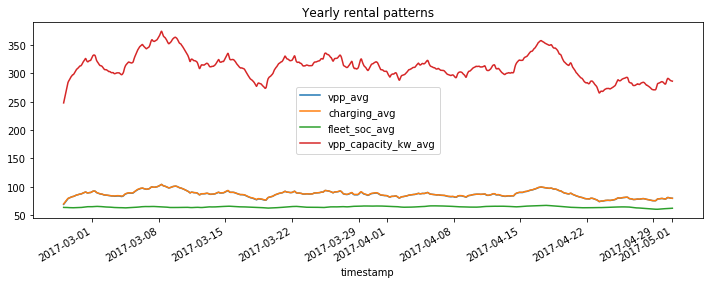

In [14]:
df = apply_smoother(df, days=3)
plot(df, "Yearly rental patterns");

## Weekly Pattern of connected EVS

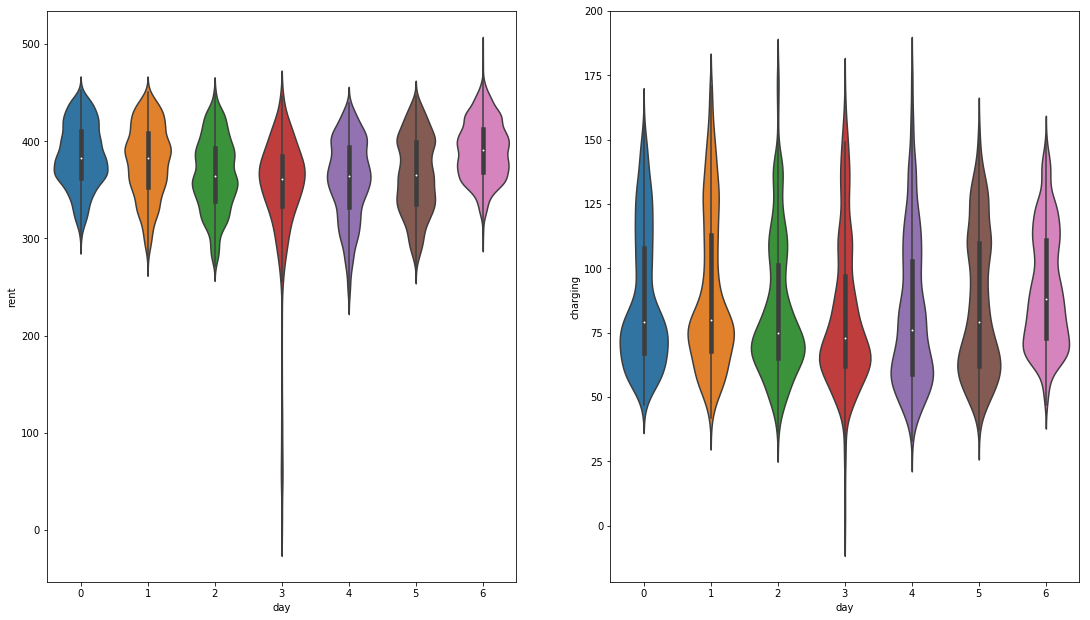

In [20]:
df["day"] = df.index.weekday

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="day", y="rent", data=df, ax=ax1)
sns.violinplot(x="day", y="charging", data=df, ax=ax2);

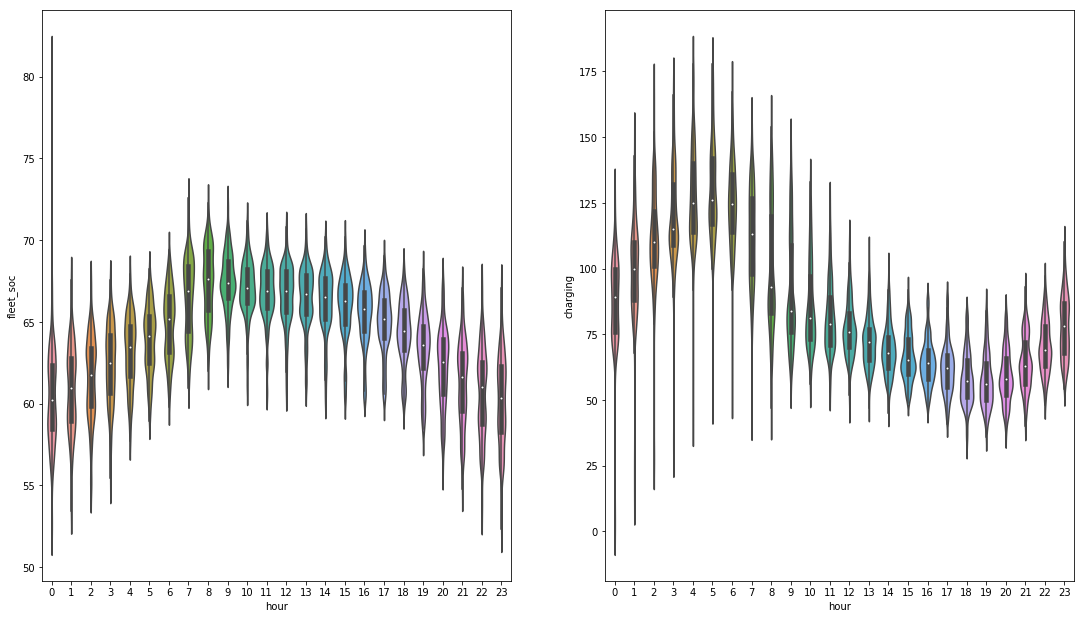

In [16]:
df["hour"] = df.index.hour

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="hour", y="fleet_soc", data=df, ax=ax1)
sns.violinplot(x="hour", y="charging", data=df, ax=ax2);

**Comment**: EVs get fully charged during morning/noon and are not able to be used as vpp anymore

### Example Week

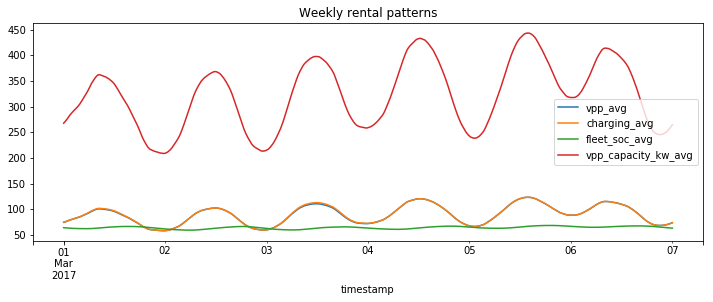

In [17]:
df = apply_smoother(df, days=0.5)
plot(df, "Weekly rental patterns", start=datetime(
    2017, 3, 1), end=datetime(2017, 3, 7))

## Daily Pattern of connected EVS

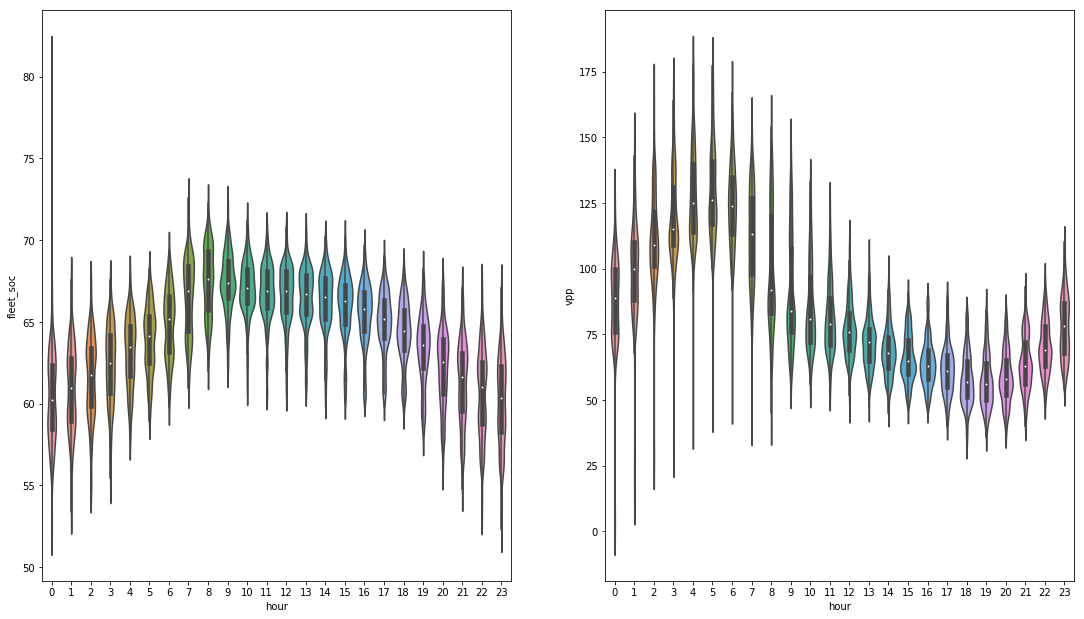

In [18]:
df["hour"] = df.index.hour

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="hour", y="fleet_soc", data=df, ax=ax1)
sns.violinplot(x="hour", y="vpp", data=df, ax=ax2);

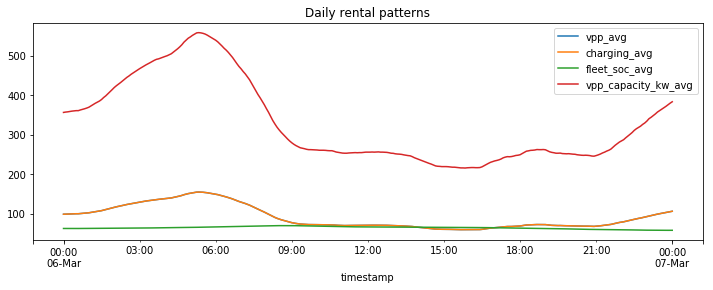

In [19]:
df = apply_smoother(df, days=1/24)
plot(df, "Daily rental patterns", start=datetime(
    2017, 3, 6), end=datetime(2017, 3, 7));